In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from IPython.display import display, Math
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dataset-1/u.item
/kaggle/input/dataset-1/u.data
/kaggle/input/dataset-1/u.user


### Introduction

I re-created an experiment that explores collaborative filtering techniques, specifically using the KNNBasic algorithm for recommendation. I loaded a dataset from a plain text file and then trained the model on it. To assess its performance, I employed cross-validation, evaluating metrics such as RMSE and MAE.

Throughout the process, I followed several steps, including data loading, model training, prediction making, and recommendation generation. My algorithm is based on user-based collaborative filtering with cosine similarity. Additionally, I visualized the model errors and retrieved nearest neighbors of an item.

In [3]:
# Load Surprise libraries
from surprise import KNNBasic
from surprise import Reader
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import cross_validate

In [4]:
# Load Plotting libraries
%matplotlib inline
import matplotlib.pyplot as plt

### 1. Loading data


In [5]:
# Path to dataset file
file_path = os.path.expanduser('/kaggle/input/dataset-1/u.data')

In [6]:
# Read the data into a Surprise dataset
reader = Reader(line_format = 'user item rating timestamp', sep = '\t', rating_scale = (1, 5))
data = Dataset.load_from_file(file_path, reader = reader)

In [7]:
#!pip install latexify-py

In [8]:
import math
import latexify

### 2. Train the model and measure its error

In [9]:
# LaTeX representation of the formula
latex_formula = r"\hat{r}_{ui} = \frac{\sum_{v \in N_{ki}(u)} \text{sim}(u,v) \cdot r_{vi}}{\sum_{v \in N_{ki}(u)} \text{sim}(u,v)}"

# Display the formula
display(Math(latex_formula))

<IPython.core.display.Math object>

In [10]:
# Use k-NN algorithm with user-based collaborative filtering and cosine similarity
kk = 50
sim_options = {'name': 'cosine', 'user_based': True}
algo = KNNBasic(k = kk, sim_options = sim_options, verbose = True)

We're setting up a recommendation system using a k-Nearest Neighbors (k-NN) algorithm for collaborative filtering. Collaborative filtering is a method for making predictions about what a user might like based on preferences from similar users.

Here's why we've chosen this specific setup:

Firstly, we're using the k-NN algorithm. It's a straightforward but powerful approach where we find the 'k' nearest neighbors to a target user based on their past ratings. Then, we use these neighbors' ratings to predict what the target user might like. It's a method that's often used in recommendation systems because of its simplicity and effectiveness.

Next, we're opting for user-based collaborative filtering. This means we're recommending items to a user based on the preferences of users who are similar to them. If two users have similar tastes, they're likely to enjoy similar items. It's intuitive and often yields good results.

For measuring similarity between users, we're using cosine similarity. This metric calculates the cosine of the angle between two vectors, providing a measure of similarity that's unaffected by the magnitude of the vectors. It's suitable for recommendation systems because it focuses on the direction of preferences rather than their magnitude.

The specific parameters we've chosen, like kk = 50 and sim_options, allow us to fine-tune the algorithm. For example, kk = 50 specifies that we'll consider the 50 nearest neighbors, and sim_options configures the similarity measure to cosine similarity. These parameters help balance prediction accuracy and computational efficiency.

In [11]:
# Run 5-fold cross-validation and print results
cv = cross_validate(algo, data, measures = ['RMSE', 'MAE'], cv = 5, verbose = True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0222  1.0101  1.0133  1.0190  1.0198  1.0169  0.0045  
MAE (testset)     0.8073  0.7983  0.8009  0.8078  0.8068  0.8042  0.0039  
Fit time          0.69    0.71    0.66    0.69    0.73    0.70    0.02    
Test time         5.95    6.19    6.58    6.17    6.08    6.19    0.21    


It's nice to see that the algorithm's performance doesn't vary much across different parts of the dataset. The standard deviations for RMSE and MAE are pretty small, which tells us that it's giving consistent results across the board.

The errors (RMSE and MAE) aren't too high, which means it's making decent guesses about what users might like. The RMSE values are around 1.0169 on average, and the MAE values hover around 0.8042

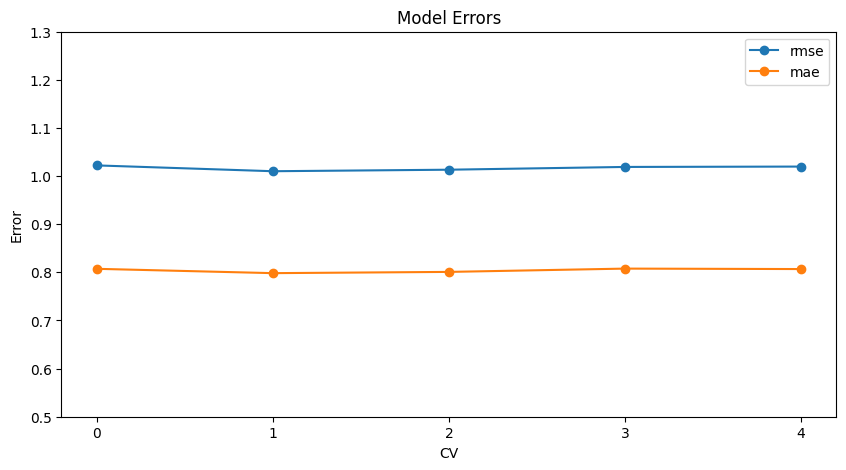

In [12]:
# Get data
rmse = cv['test_rmse']
mae = cv['test_mae']
x = np.arange(len(rmse))

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize = (10, 5))
plt.xticks(np.arange(min(x), max(x) + 1, 1.0))
plt.ylim(0.5, 1.3)
ax.plot(x, rmse, marker='o', label="rmse")
ax.plot(x, mae, marker='o', label="mae")

# Chart setup
plt.title("Model Errors", fontsize = 12)
plt.xlabel("CV", fontsize = 10)
plt.ylabel("Error", fontsize = 10)
plt.legend()
plt.show()

### 3. Make some predictions

In [13]:
# Without real rating
p1 = algo.predict(uid = '13', iid = '181', verbose = True)

user: 13         item: 181        r_ui = None   est = 4.04   {'actual_k': 50, 'was_impossible': False}


In [14]:
# With real rating
p2 = algo.predict(uid = '196', iid = '302', r_ui = 4, verbose = True)

user: 196        item: 302        r_ui = 4.00   est = 4.02   {'actual_k': 50, 'was_impossible': False}


### 4. Get the k nearest neighbors of an item

In [15]:
import os
import io

In [16]:
# Return two mappings to convert raw ids into movie names and movie names into raw ids
def read_item_names(file_path):
    rid_to_name = {}
    name_to_rid = {}
    
    with io.open(file_path, 'r', encoding = 'ISO-8859-1') as f:
        for line in f:
            line = line.split('|')
            rid_to_name[line[0]] = line[1]
            name_to_rid[line[1]] = line[0]
    
    return rid_to_name, name_to_rid

#we are using the above function as it allows for easy conversion between raw movie IDs and movie names, facilitating tasks such as displaying movie names based on their IDs and vice versa.

In [17]:
# Read the mappings raw id <-> movie name
item_filepath = '/kaggle/input/dataset-1/u.item'
rid_to_name, name_to_rid = read_item_names(item_filepath)

In [18]:
# Target movie
target_movie = 'Toy Story (1995)'

In [19]:
# Retrieve inner id of the movie Toy Story
toy_story_raw_id = name_to_rid[target_movie]
toy_story_inner_id = algo.trainset.to_inner_iid(toy_story_raw_id)
print(target_movie + ':', toy_story_inner_id)

Toy Story (1995): 111


In [20]:
# Retrieve inner ids of the nearest neighbors of Toy Story
toy_story_neighbors = algo.get_neighbors(toy_story_inner_id, k = 10)
toy_story_neighbors

[13, 44, 54, 91, 96, 100, 102, 106, 117, 148]

In [21]:
# The 10 nearest neighbors of Toy Story are:
print("The movies most similar to '" + target_movie + " are:")

for inner_id in toy_story_neighbors:
    raw_id = algo.trainset.to_raw_iid(inner_id)
    movie = rid_to_name[raw_id]
    print(raw_id, '-', movie)

The movies most similar to 'Toy Story (1995) are:
177 - Good, The Bad and The Ugly, The (1966)
434 - Forbidden Planet (1956)
606 - All About Eve (1950)
1052 - Dracula: Dead and Loving It (1995)
194 - Sting, The (1973)
656 - M (1931)
174 - Raiders of the Lost Ark (1981)
685 - Executive Decision (1996)
607 - Rebecca (1940)
16 - French Twist (Gazon maudit) (1995)


### 5. Get the top-N recommendations


In [22]:
# Return the top-N recommendation for each user from a set of predictions.
def get_top_n(predictions, n = 10):
    
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
        
    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
    
    return top_n

The `get_top_n` function efficiently generates personalized recommendations for users based on predictions made by a recommendation algorithm. It achieves this by first grouping the predictions according to user IDs, creating a mapping that associates each user with a list of predicted ratings for different items. This initial organization lays the groundwork for subsequent steps in the recommendation process.

In [23]:
# Create train_set and test_set
train_set = data.build_full_trainset()
test_set = train_set.build_anti_testset()

# First train a KNN algorithm on the whole dataset
algo.fit(train_set)
predictions = algo.test(test_set)

# RMSE should be low as we are biased
accuracy.rmse(predictions, verbose = True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9255


0.9254759689787458

With an RMSE of around 0.9255, the recommendation system appears to be performing reasonably well. It implies that, on average, the algorithm's predicted ratings are about 0.9255 units away from the actual ratings in the dataset.

In [24]:
from collections import defaultdict

In [25]:
# Than predict ratings for all pairs (u, i) that are NOT in the training set
top_n = 10
top_pred = get_top_n(predictions, n = top_n)
# User raw Id
uid_list = ['196']

# Print the recommended items for a specific user
for uid, user_ratings in top_pred.items():
    if uid in uid_list:
        for (iid, rating) in user_ratings:
            movie = rid_to_name[iid]
            print('Movie:', iid, '-', movie, ', rating:', str(rating))

Movie: 1189 - Prefontaine (1997) , rating: 5
Movie: 1500 - Santa with Muscles (1996) , rating: 5
Movie: 814 - Great Day in Harlem, A (1994) , rating: 5
Movie: 1536 - Aiqing wansui (1994) , rating: 5
Movie: 1293 - Star Kid (1997) , rating: 5
Movie: 1599 - Someone Else's America (1995) , rating: 5
Movie: 1653 - Entertaining Angels: The Dorothy Day Story (1996) , rating: 5
Movie: 1467 - Saint of Fort Washington, The (1993) , rating: 5
Movie: 1122 - They Made Me a Criminal (1939) , rating: 5
Movie: 1201 - Marlene Dietrich: Shadow and Light (1996)  , rating: 5


In [26]:
# import networkx as nx
#import matplotlib.pyplot as plt/***  

# Create a new graph
#G = nx.Graph()

# Add nodes for users and items
#for uid, iid, _, _, _ in predictions:
  #  G.add_node(uid, type='user')
 #   G.add_node(iid, type='item')

# Add edges representing interactions (ratings) between users and items
#for uid, iid, _, _, _ in predictions:
 #   G.add_edge(uid, iid)

# Plot the graph
#plt.figure(figsize=(12, 8))
#pos = nx.spring_layout(G, seed=42)  # Position nodes using a spring layout algorithm
#nx.draw(G, pos, with_labels=False, node_size=50, node_color='skyblue', edge_color='gray', alpha=0.7)
#plt.title('Interconnected Graph of Testing Dataset')
#plt.show()  